#### Import required packages

In [668]:
# numeric and plotting libraries
import time
import os
import shutil
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from PIL import Image
import csv
import operator 
import pandas as pd 
# to create confusion metrics
import seaborn as sns
import scipy.io as sio
from cmath import nan
from cmath import isnan

In [669]:
from ipynb.fs.full.data_prep import *

In [670]:
%matplotlib inline

In [679]:
from sklearn.metrics import accuracy_score,confusion_matrix # metrics error
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Classification on anest and awake state

#### Data preparation

In [680]:
def ucitavanje_podataka(directory):
    id = 0
    data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        label = f.split("\\")[-1][0:2]
        id = id + 1
        dat = np.load(f)
        data.append([id, dat, label])
    
    random.seed(2)
    #random.shuffle(data)
    return data      

In [681]:
def vektorizacija(podaci):
    prevodjenje_labela = {"an": [1], "aw": [0]}  # anest: 1, aw: 0

    vektorizovani_podaci = []
    for a in podaci:
        vektorizovani_podaci.append([a[0], a[1], prevodjenje_labela[a[2]]])

    return vektorizovani_podaci

In [682]:
def podela_podataka(data_vectors):
    max = 0
    for i in range(0,len(data_vectors)):
        if(data_vectors[i][1].shape[0] > max):
            max = data_vectors[i][1].shape[0]

    X_train, y_train, X_test, y_test = np.empty([1, max, data_vectors[0][1].shape[1]]), [], np.empty([1, max, data_vectors[0][1].shape[1]]),[]
    i,j = 0,0

    max_norm = 0
    min_norm = 50
    for a in data_vectors:
        for x in a[1]:
            for y in x:
                if(y > max_norm):
                    max_norm = y
                if(y < min_norm):
                    min_norm = y

    for a in range(0, len(data_vectors)):
        for x in range(0, len(data_vectors[a][1])):
            for y in range(0, len(data_vectors[a][1][x])):
                data_vectors[a][1][x][y] = (data_vectors[a][1][x][y] - min_norm) / (max_norm - min_norm)

    random.shuffle(data_vectors)
    for item in data_vectors:
        if item[2]==[1]:
            i = i + 1
            if i <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant' , constant_values=0)
                X_test = np.append(X_test, np.array(item[1]).reshape(1, item[1].shape[0], np.array(item[1]).shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_train.append(item[2])
        else:
            j = j + 1
            if  j <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_test = np.append(X_test, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, np.array(item[1]).reshape(1, np.array(item[1]).shape[0], np.array(item[1]).shape[1]), axis=0)
                y_train.append(item[2])
    
    X_train = np.array(X_train[1:])
    y_train = np.array(y_train)
    X_test = np.array(X_test[1:])
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [683]:
def podela_podataka_tren(data_vectors):
    max = 110
    X_train, y_train = np.empty([1, max, data_vectors[0][1].shape[1]]), []

    max_norm = 0
    min_norm = 50
    for a in data_vectors:
        for x in a[1]:
            for y in x:
                if(y > max_norm):
                    max_norm = y
                if(y < min_norm):
                    min_norm = y

    for a in range(0, len(data_vectors)):
        for x in range(0, len(data_vectors[a][1])):
            for y in range(0, len(data_vectors[a][1][x])):
                data_vectors[a][1][x][y] = (data_vectors[a][1][x][y] - min_norm) / (max_norm - min_norm)

    random.shuffle(data_vectors)

    for item in data_vectors:
        if(item[1].shape[0] < max):
            item[1] = np.pad(item[1], [(0, max-item[1].shape[0]), (0, 0)], mode='constant', constant_values=0)      
        X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
        #y_train.append(item[2])
        y_train.append(random.choice([[0], [1]]))
    
    X_train = np.array(X_train[1:])
    y_train = np.array(y_train)
    
    return X_train, y_train

#### Test/Train

In [684]:
#putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
putanja = "C:/Users/m.nedeljkovic/Desktop/cnn data/data"
#niz od podataka za svaku sekvencu (podatak je niz od id-ja, sekvence i labele)
podaci = ucitavanje_podataka(putanja)
vektorizovani_podaci = vektorizacija(podaci)

X_train, y_train, X_test, y_test = podela_podataka(vektorizovani_podaci)
X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)
X_test = np.array(X_test, dtype=object)
y_test = np.array(y_test)

In [685]:
X_tr = []
for i in X_train:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_tr.append(temp)
X_train = np.array(X_tr, dtype=object)

X_ts = []
for i in X_test:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_ts.append(temp) 
X_test = np.array(X_ts, dtype=object)

### KNN

In [686]:
knn = OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train,y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [687]:
predictions = knn.predict(X_test)

In [688]:
print('KNN Accuracy: %.3f' % accuracy_score(y_test,predictions))

KNN Accuracy: 1.000


Text(0.5, 1.0, 'Accuracy Score: 1.0')

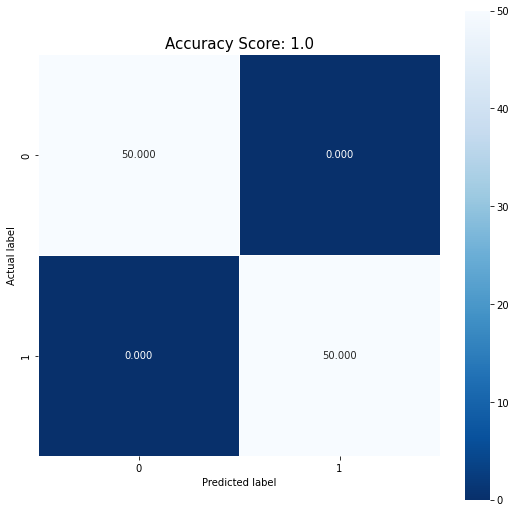

In [689]:
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,predictions))
plt.title(all_sample_title,size=15)

### Random Forest

##### Implementation

In [690]:
def RF(X_train, y_train, X_test, y_test):
    forest = RandomForestClassifier(criterion='gini',
                                    n_estimators=5,
                                    random_state=1,
                                    n_jobs=2)

    forest.fit(X_train, y_train)

    y_pred = forest.predict(X_test)

    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    
    return y_pred

In [691]:
def mat_of_conf(y_test,y_pred,br1,br2):
    cm = confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred))
    plt.title(all_sample_title,size=15)
    plt.savefig("C:/Users/m.nedeljkovic/Desktop/ses/ses_" + str(br1) + "_" + str(br2) + ".jpeg")

Accuracy: 1.000


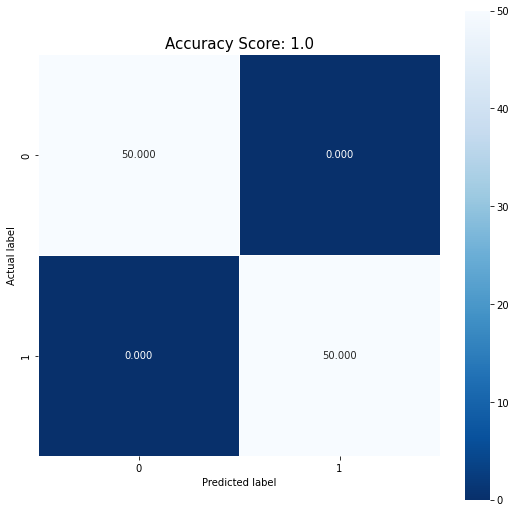

In [693]:
Forest = RF(X_train, y_train, X_test, y_test)
mat_of_conf(y_test,Forest)

##### Iterating over different regions

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from cmath import isnan

#putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
putanja = "C:/Users/m.nedeljkovic/Desktop/cnn data/data"
mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()

for br1 in range(1,13):
    for br2 in range(1,13):
        if(br1!=br2):
            print("Trained on region " + str(br1) + ", and tested on region " + str(br2))

            for file_name in os.listdir(putanja):
                # construct full file path
                file = putanja + "/" + file_name
                os.remove(file)

            mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()
            data_per_trial(1, mat_load, roi_load, ind_load, list1, list2, list3, list4)

            #niz od podataka za svaku sekvencu (podatak je niz od id-ja, sekvence i labele)
            podaci = ucitavanje_podataka(putanja)
            vektorizovani_podaci = vektorizacija(podaci)

            X_train, y_train, X_test, y_test = podela_podataka(vektorizovani_podaci)
            X_train = np.array(X_train, dtype=object)
            y_train = np.array(y_train)
            X_test = np.array(X_test, dtype=object)
            y_test = np.array(y_test)

            X_tr = []
            for i in X_train:
                temp = []
                for j in i:
                    for k in j:
                        if(isnan(k)):
                            k = 0
                        temp.append(k)
                X_tr.append(temp)
            X_train = np.array(X_tr, dtype=object)

            X_ts = []
            for i in X_test:
                temp = []
                for j in i:
                    for k in j:
                        if(isnan(k)):
                            k = 0
                        temp.append(k)
                X_ts.append(temp) 
            X_test = np.array(X_ts, dtype=object)
            Forest = RF(X_train, y_train, X_test, y_test)
            mat_of_conf(y_test,Forest,br1,br2)


### Iterating over different sessions knn and rf

In [696]:
import warnings
warnings.filterwarnings('ignore')

#putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
putanja = "C:/Users/m.nedeljkovic/Desktop/cnn data/data"

mat_load, roi_load, ind_load, list1, list2, list3, list4 = load_data()

for tr in range(1,13):

    X_train, X_test, y_train, y_test = [], [], [], []

    br1 = 3
    for br in [0,1,2]:

        for file_name in os.listdir(putanja):
            # construct full file path
            file = putanja + "/" + file_name
            os.remove(file)

        data_per_ses(tr, br, mat_load, roi_load, ind_load, list1, list2, list3, list4)
        podaci = ucitavanje_podataka(putanja)
        vektorizovani_podaci = vektorizacija(podaci)
        X_train_, y_train_ = podela_podataka_tren(vektorizovani_podaci)
        X_tr = []
        for i in X_train_:
            temp = []
            for j in i:
                for k in j:
                    if(isnan(k)):
                        k = 0
                    temp.append(k)
            X_tr.append(temp)
        X_train_ = np.nan_to_num(X_tr)

        for mm in X_train_:
            X_train.append(mm)
        for mm in y_train_:
            y_train.append(mm)

    for file_name in os.listdir(putanja):
        # construct full file path
        file = putanja + "/" + file_name
        os.remove(file)

    data_per_ses(tr, br1, mat_load, roi_load, ind_load, list1, list2, list3, list4)
    podaci = ucitavanje_podataka(putanja)
    vektorizovani_podaci = vektorizacija(podaci)
    X_train_, y_train_ = podela_podataka_tren(vektorizovani_podaci)
    X_tr = []
    for i in X_train_:
        temp = []
        for j in i:
            for k in j:
                if(isnan(k)):
                    k = 0
                temp.append(k)
        X_tr.append(temp)
    X_train_ = np.nan_to_num(X_tr)

    for mm in X_train_:
        X_test.append(mm)
        
    for mm in y_train_:
        y_test.append(mm)
    
    X_train = np.array(X_train, dtype=object)
    y_train = np.array(y_train)
    X_test = np.array(X_test, dtype=object)
    y_test = np.array(y_test)
            
    knn = OneVsRestClassifier(KNeighborsClassifier())
    knn.fit(X_train,y_train)
    predictions = knn.predict(X_test)
    knn_acc = accuracy_score(y_test,predictions)

    Forest = RF(X_train, y_train, X_test, y_test)
    rf = accuracy_score(y_test,Forest)

    model = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 0.1, n_estimators = 12,  eta=0.05)
    model.fit(X_train, y_train)

    # make predictions for test set
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    accuracy = accuracy_score(y_test, predictions)

    print("KNN: ", knn_acc)
    print("RF: ", rf)
    print("XGB: ", accuracy)

    break


Accuracy: 0.600
[17:53:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
KNN:  0.59
RF:  0.6
XGB:  0.6


# Classification on 5 different speakers

#### Data preparation

In [703]:
def ucitavanje_sp(directory):
    id = 0
    data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        label = [int(f.split("\\")[-1][-5:-4])]
        id = id + 1
        dat = np.load(f)
        data.append([id, dat, label])
    
    #random.seed(2)
    random.shuffle(data)
    return data      

In [704]:
def podela_podataka_sp(data_vectors):
    
    max = 0
    for i in range(0,len(data_vectors)):
        if(data_vectors[i][1].shape[0] > max):
            max = data_vectors[i][1].shape[0]

    max_norm = 0
    min_norm = 50
    for a in data_vectors:
        for x in a[1]:
            for y in x:
                if(y > max_norm):
                    max_norm = y
                if(y < min_norm):
                    min_norm = y

    for a in range(0, len(data_vectors)):
        for x in range(0, len(data_vectors[a][1])):
            for y in range(0, len(data_vectors[a][1][x])):
                data_vectors[a][1][x][y] = (data_vectors[a][1][x][y] - min_norm) / (max_norm - min_norm)


    X_train, y_train, X_test, y_test = np.empty([1, max, data_vectors[0][1].shape[1]]), [], np.empty([1, max, data_vectors[0][1].shape[1]]),[]
    
    i1,i2,i3,i4,i5 = 0,0,0,0,0

    random.shuffle(data_vectors)
    for item in data_vectors:

        if item[2]==[0]:
            i1 = i1 + 1
            if i1 <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant' , constant_values=0)
                X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_test.append([0])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_train.append([0])
            '''
            elif item[2]==[1]:
                i2 = i2 + 1
                if  i2 <= 50:
                    if(np.array(item[1]).shape[0] < max):
                        item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                    X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                    y_test.append(item[2])
                    #y_test.append(random.choice([[0], [1]]))
                else:
                    if(np.array(item[1]).shape[0] < max):
                        item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                    X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                    y_train.append(item[2])
            elif item[2]==[2]:
                i3 = i3 + 1
                if  i3 <= 50:
                    if(np.array(item[1]).shape[0] < max):
                        item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                    X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                    y_test.append(item[2])
                    #y_test.append(random.choice([[0], [1]]))
                else:
                    if(np.array(item[1]).shape[0] < max):
                        item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                    X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                    y_train.append(item[2])
                '''
        elif item[2]==[4]:
            i4 = i4 + 1
            if  i4 <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_test.append([1])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_train.append([1])
        '''
        else:
            i5 = i5 + 1
            if  i5 <= 50:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_test = np.append(X_test, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_test.append(item[2])
                #y_test.append(random.choice([[0], [1]]))
            else:
                if(np.array(item[1]).shape[0] < max):
                    item[1] = np.pad(item[1], [(0, max-np.array(item[1]).shape[0]), (0, 0)], mode='constant', constant_values=0)
                X_train = np.append(X_train, item[1].reshape(1, item[1].shape[0], item[1].shape[1]), axis=0)
                y_train.append(item[2])
        '''
    
    X_train = np.array(X_train[1:])
    y_train = np.array(y_train)
    X_test = np.array(X_test[1:])
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

#### Test / Train set

In [803]:
#putanja = "C:/Users/Zephyrus/Desktop/cnn data/data"
putanja = "C:/Users/m.nedeljkovic/Desktop/cnn data/data"
#niz od podataka za svaku sekvencu (podatak je niz od id-ja, sekvence i labele)
podaci = ucitavanje_sp(putanja)
X_train, y_train, X_test, y_test = podela_podataka_sp(podaci)

X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)
X_test = np.array(X_test, dtype=object)
y_test = np.array(y_test)

In [804]:
X_tr = []
for i in X_train:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_tr.append(temp)
X_train = np.array(X_tr, dtype=object)

X_ts = []
for i in X_test:
    temp = []
    for j in i:
        for k in j:
            if(isnan(k)):
                k = 0
            temp.append(k)
    X_ts.append(temp) 
X_test = np.array(X_ts, dtype=object)

### KNN

In [805]:
knn = OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train,y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [806]:
predictions = knn.predict(X_test)

In [807]:
print('KNN Accuracy: %.3f' % accuracy_score(y_test,predictions))

KNN Accuracy: 0.610


Text(0.5, 1.0, 'Accuracy Score: 0.61')

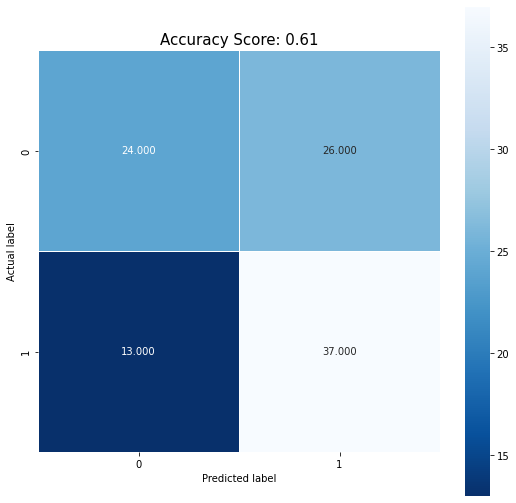

In [808]:
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,predictions))
plt.title(all_sample_title,size=15)

### Random Forest

In [809]:
def RF(X_train, y_train, X_test, y_test):
    forest = RandomForestClassifier(criterion='gini',
                                    n_estimators=5,
                                    random_state=1,
                                    n_jobs=2)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    return y_pred

In [810]:
def mat_of_conf(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm,annot=True, fmt='.3f', linewidths=.5, square=True,cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred))
    plt.title(all_sample_title,size=15)
    plt.show()

Accuracy: 0.650


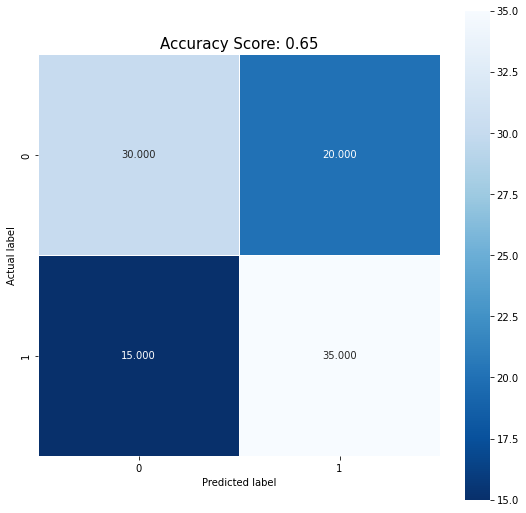

In [811]:
Forest = RF(X_train, y_train, X_test, y_test)
mat_of_conf(y_test,Forest)

### XG boost

[18:31:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-logloss:0.63780	validation_1-logloss:0.67932
[1]	validation_0-logloss:0.58845	validation_1-logloss:0.65687
[2]	validation_0-logloss:0.54259	validation_1-logloss:0.63699
[3]	validation_0-logloss:0.50799	validation_1-logloss:0.62882
[4]	validation_0-logloss:0.47752	validation_1-logloss:0.62891
[5]	validation_0-logloss:0.45016	validation_1-logloss:0.61554
[6]	validation_0-logloss:0.42720	validation_1-logloss:0.61107
[7]	validation_0-logloss:0.40102	validation_1-logloss:0.60929
[8]	validation_0-logloss:0.37987	validation_1-logloss:0.60567
[9]	validation_0-logloss:0.36076	validation_1-logloss:0.60908
[10]	validation_0-logloss:0.34390	validation_1-logloss:0.60490
[11]	validation_0-logloss:0.33148	validation_1-logloss:0.60715
[12]	validation_0-logloss:0.31666	validation_1-logloss:0.61161
[13]	validatio

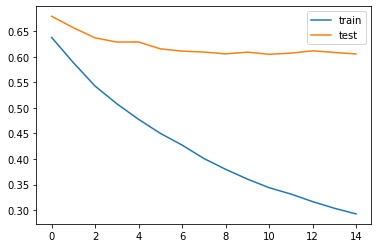

In [819]:
eval = [(X_train, y_train),(X_test, y_test)]
classif = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 0.1, n_estimators = 15,  eta=0.05)
classif.fit(X_train,y_train, eval_set = eval, eval_metric='logloss')
preds = classif.predict(X_test)
score = accuracy_score(y_test, preds)
print('Accuracy: %.3f' % score)
results = classif.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.show()

In [813]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#instantiate model and train
model = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 0.1, n_estimators = 20,  eta=0.05)
model.fit(X_train, y_train)

# make predictions for test set
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[18:31:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: 72.00%


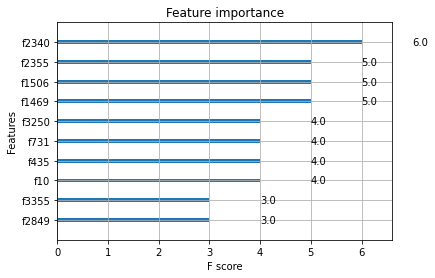

In [814]:
from turtle import width
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
plot_importance(model, max_num_features=10)
plt.show()

x = model.feature_importances_

In [815]:
max(x)

0.046086375